In [21]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from statsmodels.tsa.arima.model import ARIMA
import os
import string
import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import statsmodels.api as sm
import warnings

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [22]:
#electricity consumption data
electr_residential = pd.read_csv('../../../data/tidy/residential-electricity-2016to2022.csv') 
electr_commer_indust = pd.read_csv('../../../data/tidy/commercial-electricity-2016to2022.csv')

electr_commer_indust = electr_commer_indust.iloc[::-1]

# If you want to reset the index after flipping, you can do:
electr_commer_indust.reset_index(drop=True, inplace=True)
electr_commer_indust.set_index('Unnamed: 0', inplace=True)
electr_commer_indust.index.name = 'index'
electr_commer_indust.drop(electr_commer_indust.columns[0], axis=1, inplace=True)


electr_residential = electr_residential.iloc[::-1]

# If you want to reset the index after flipping, you can do:
electr_residential.reset_index(drop=True, inplace=True)
electr_residential.set_index('Unnamed: 0', inplace=True)
electr_residential.index.name = 'index'
electr_residential.drop(electr_residential.columns[0], axis=1, inplace=True)

electric_results = electr_commer_indust+electr_residential

#assuming constant emissions factor
Total_EF = 543.852

electric_results = electric_results/1000*Total_EF/2204.62/1000000 #unit (MMTCO2e)

# Define new column names
new_column_names = ['New Haven (MMTCO2e)', 'Hartford (MMTCO2e)', 'Bridgeport (MMTCO2e)']

# Assign new column names to the DataFrame
electric_results.columns = new_column_names

electric_results.index.name = 'year'


electric_results.index = pd.to_datetime(electric_results.index, format='%Y')
electric_results.index.freq = 'AS'
df=electric_results
df

,New Haven (MMTCO2e),Hartford (MMTCO2e),Bridgeport (MMTCO2e)
year,,,
2016-01-01,1.430073,1.924097,1.792147
2017-01-01,1.355028,2.231089,1.706469
2018-01-01,1.449108,2.108849,1.726713
2019-01-01,1.374215,1.844642,1.674141
2020-01-01,1.303380,1.756536,1.590311
2021-01-01,1.314940,1.790219,1.671623
2022-01-01,1.353627,1.842788,1.688185


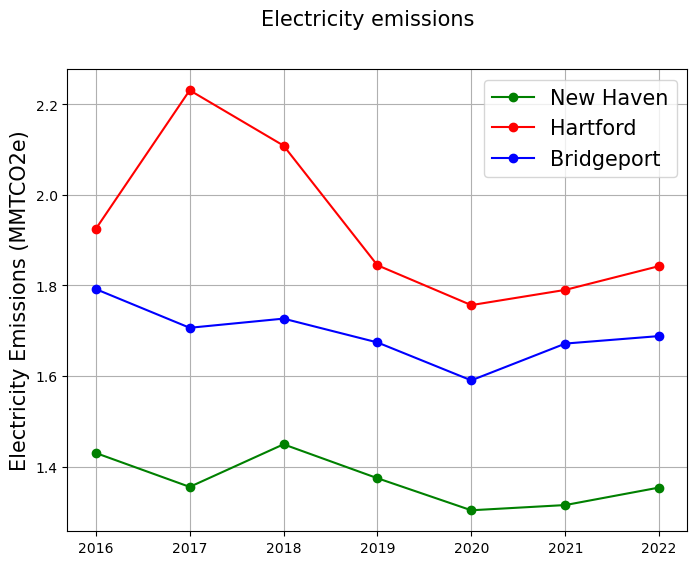

In [23]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Electricity emissions',fontsize=15)
actual, = plt.plot(df.index, df['New Haven (MMTCO2e)'], 'go-', label='New Haven')
actual, = plt.plot(df.index, df['Hartford (MMTCO2e)'], 'ro-', label='Hartford')
actual, = plt.plot(df.index, df['Bridgeport (MMTCO2e)'], 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('Electricity Emissions (MMTCO2e)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/electricity-emissions-historical-change.png', dpi=600, bbox_inches='tight')

In [24]:
#split the test and trainig set
split_index = round(len(df)*0.6)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()


df_train.index.freq = 'AS'
df_test.index.freq = 'AS'

In [25]:
len(df_test)

3

In [26]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['New Haven (MMTCO2e)'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -1.975987
p-value: 0.297200


In [27]:
HEM_data = df['Hartford (MMTCO2e)']
NHM_data = df['New Haven (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']

In [28]:
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

def evaluate_forecast(test, forecast):#observed and predicted
    """
    Evaluate forecast using different metrics.
    """
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

def arima_prediction(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Generate predictions for the test set
    pred = res.get_prediction(start=len(train), end=len(train) + len(test) - 1)
    pred_mean = pred.predicted_mean
    
    # Evaluate forecast
    mape, mae, rmse = evaluate_forecast(test, pred_mean)
    
    # Calculate BIC and AIC
    #bic = res.bic
    #aic = res.aic
    
    return mape, mae, rmse

def gridsearch(data): 
    
    n_splits = 3  # You can adjust this value as needed

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize list to store results
    results_list_cv = []

    p_values = range(0,10)
    d_values = range(0,3)
    q_values = range(0,10)

    # Loop through each combination of p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mape_cv = []
                mae_cv = []
                rmse_cv = []
                #bic_cv = []
                #aic_cv = []

                # Perform cross-validation
                for train_index, test_index in tscv.split(data):
                    train, test = data[train_index], data[test_index]
                    mape, mae, rmse = arima_prediction(train, test, order)
                    mape_cv.append(mape)
                    mae_cv.append(mae)
                    rmse_cv.append(rmse)
                    #bic_cv.append(bic) in-sample error-biased
                    #aic_cv.append(aic)
#do train-test split,manualy: rmse; average k-fold error;validation set approach; small scale test:validation. 
                # Calculate the mean of metrics across folds
                mape_mean = np.mean(mape_cv)
                mae_mean = np.mean(mae_cv)
                rmse_mean = np.mean(rmse_cv)
                #bic_mean = np.mean(bic_cv)
                #aic_mean = np.mean(aic_cv)

                # Store results
                results_list_cv.append({'p': p, 'd': d, 'q': q, 'MAPE': mape_mean, 'MAE': mae_mean, 'RMSE': rmse_mean})
                                        #BIC': bic_mean, 'AIC': aic_mean})

    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results_list_cv)
    return results_df
            
# Convert list of dictionaries to DataFrame
results_df_HEM_cv=gridsearch(HEM_data)
results_df_NHM_cv=gridsearch(NHM_data)
results_df_BSN_cv=gridsearch(BSN_data)

print(results_df_HEM_cv)

     p  d  q       MAPE       MAE      RMSE
0    0  0  0  11.291192  0.201172  0.201172
1    0  0  1   7.028664  0.124130  0.124130
2    0  0  2   3.030582  0.054062  0.054062
3    0  0  3   7.235766  0.128580  0.128580
4    0  0  4   9.490840  0.168677  0.168677
..  .. .. ..        ...       ...       ...
295  9  2  5   5.951116  0.105592  0.105592
296  9  2  6   5.951116  0.105592  0.105592
297  9  2  7   5.951116  0.105592  0.105592
298  9  2  8   5.951116  0.105592  0.105592
299  9  2  9   5.951116  0.105592  0.105592

[300 rows x 6 columns]


In [29]:
test_HEM =results_df_HEM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
test_HEM.sort_values(by='RMSE').iloc[:10,:]

MAPE       MAE      RMSE
p d q                              
0 1 1  2.501155  0.044987  0.044987
3 1 1  2.732913  0.048503  0.048503
    0  2.733640  0.048516  0.048516
    2  2.733652  0.048517  0.048517
1 1 1  2.792171  0.049449  0.049449
3 1 3  2.933286  0.052282  0.052282
  0 2  2.974333  0.052749  0.052749
0 0 2  3.030582  0.054062  0.054062
2 1 3  3.108648  0.055514  0.055514
4 1 2  3.200601  0.057208  0.057208

In [30]:
test_NHM =results_df_NHM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
test_NHM.sort_values(by='RMSE').iloc[:10,:]

MAPE       MAE      RMSE
p d q                              
2 0 2  1.912651  0.024947  0.024947
  1 2  2.284457  0.029951  0.029951
  2 2  2.602430  0.034367  0.034367
4 2 2  2.860459  0.037860  0.037860
5 2 2  2.860459  0.037860  0.037860
4 2 1  2.860459  0.037860  0.037860
5 2 1  2.860459  0.037860  0.037860
0 2 0  2.860459  0.037860  0.037860
6 2 0  2.860459  0.037860  0.037860
7 2 0  2.860459  0.037860  0.037860

In [31]:
test_BSN =results_df_BSN_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
test_BSN.sort_values(by='RMSE').iloc[:10,:]

MAPE       MAE      RMSE
p d q                              
0 0 0  2.688794  0.043082  0.043082
4 0 0  3.046147  0.048651  0.048651
5 0 0  3.346859  0.053654  0.053654
4 0 1  3.378809  0.054192  0.054192
5 0 1  3.435247  0.055146  0.055146
0 0 2  3.382460  0.055330  0.055330
9 0 0  3.451731  0.055424  0.055424
2 0 9  3.451731  0.055424  0.055424
    8  3.451731  0.055424  0.055424
    7  3.451731  0.055424  0.055424

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Hartford (MMTCO2e)   No. Observations:                    7
Model:                 ARIMA(0, 1, 1)   Log Likelihood                   2.623
Date:                Thu, 11 Apr 2024   AIC                             -1.247
Time:                        20:07:03   BIC                             -1.663
Sample:                    01-01-2016   HQIC                            -2.914
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9754     17.820      0.055      0.956     -33.952      35.903
sigma2         0.0181      0.308      0.059      0.953      -0.585       0.621
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.31   Prob(JB):                         0.98
Heteroskedasticity (H):               0.03   Skew:                             0.07
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

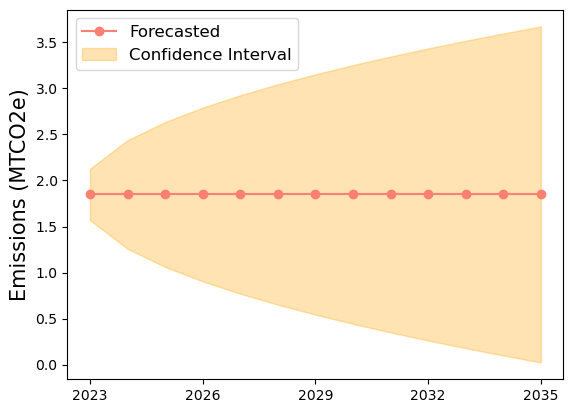

In [49]:
def arima_forecast(train, test, order,forecast_horizon,plot_file,color1,color2):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order)
    #what are existing forecasting, few slides 
    res = mod.fit()

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2023, 2023 + forecast_horizon)
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel('Emissions (MTCO2e)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3 # Change this value to set the desired interval

# Set x-ticks with the specified interval
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))

    # Save the plot
    plt.savefig(plot_file)

    return res,forecast,confidence_interval

HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
HEM_data = df['Hartford (MMTCO2e)']
plot_file = '../../../figures/hartford-forecast-emissions-electricity.png'  # File to save the plot

HEM_summary,HEM_forecast,HEM_confidence_interval=arima_forecast(HEM_data, HEM_test,(0,1,1),13, plot_file,'salmon','orange')#chagne the function name. make function shorter; call old function in new function
HEM_summary.summary()

In [50]:
HEM_summary.pvalues

ma.L1     0.956350
sigma2    0.953116
dtype: float64

In [33]:
def arima_test_data_performance_metrics(train, test,order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2023-len(test),2023)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index


    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    
    test_forecast_df.index = pd.to_datetime(test_forecast_df.index, format='%Y')


    actual_values = test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

    return mae, rmse, mape

HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
mae, rmse, mape = arima_test_data_performance_metrics(HEM_train, HEM_test,(1,1,1))
print(mae)
print(rmse)
print(mape)

0.29451227372880223
0.3285652511032441
16.242026516508616


const     1.239739e-239
ar.L1      8.101571e-01
ar.L2      9.115242e-01
ma.L1      9.999856e-01
ma.L2      9.936089e-01
sigma2     9.935414e-01
dtype: float64

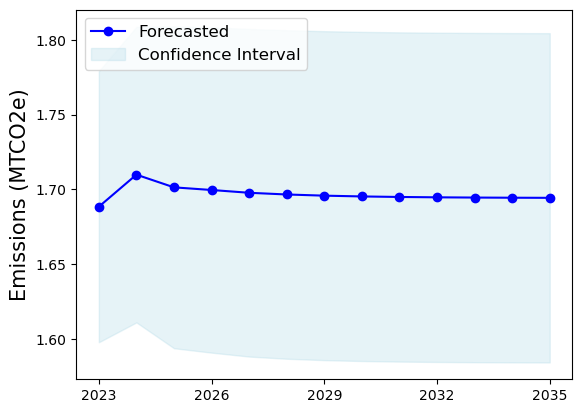

In [52]:
BSN_train = df_train['Bridgeport (MMTCO2e)']
BSN_test = df_test['Bridgeport (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']
plot_file = '../../../figures/bridgeport-forecast-emissions-electricity.png'  # File to save the plot

BSN_summary,BSN_forecast,BSN_confidence_interval=arima_forecast(BSN_data, BSN_test,(2,0,2),13, plot_file,'blue','lightblue')#chagne the function name. make function shorter; call old function in new function
BSN_summary.pvalues

In [35]:
mae, rmse, mape = arima_test_data_performance_metrics(BSN_train, BSN_test,(5,0,1))
print(mae,rmse, mape)

0.07482809850299632 0.08618990284126378 4.606386453667134


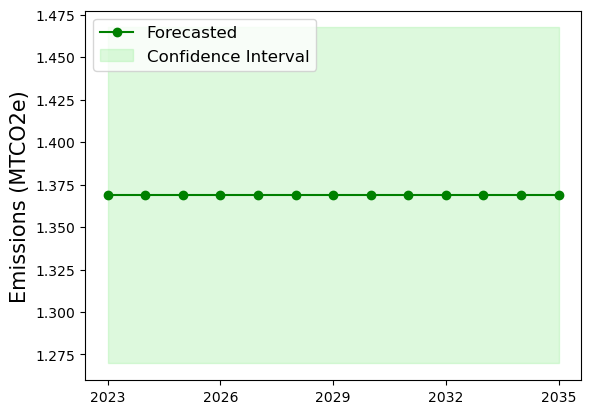

In [36]:
NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
NHM_data = df['New Haven (MMTCO2e)']
plot_file = '../../../figures/newhaven-forecast-emissions-electricity.png'  # File to save the plot

NHM_summary,NHM_forecast,NHM_confidence_interval=arima_forecast(NHM_data, NHM_test, (0,0,0),13, plot_file,'green','lightgreen')#chagne the function name. make function shorter; call old function in new function

In [37]:
NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
mae, rmse, mape = arima_test_data_performance_metrics(NHM_train, NHM_test,(5,0,0))
print(mae, rmse, mape)

0.07812361959610377 0.08102451082249264 5.92830353771236


In [38]:
def test_train_fitting_VMT(train,order):
    # Forecast on training data
    mod = sm.tsa.arima.ARIMA(train, order=order)
    res = mod.fit()
    
    train_forecast = res.get_prediction(start=0, end=len(train)-1)
    train_forecast_mean = train_forecast.predicted_mean.iloc[1:]
    train_conf_int = train_forecast.conf_int().iloc[1:]

    #test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    #test_forecast_mean = test_forecast.predicted_mean
    #test_conf_int = test_forecast.conf_int()
    
    return train_forecast_mean,train_conf_int
    

emissions_train_HEM,train_conf_int_HEM=test_train_fitting_VMT(HEM_data,(0,1,1))
emissions_train_NHM,train_conf_int_NHM=test_train_fitting_VMT(NHM_data,(2,0,2))
emissions_train_BSN,train_conf_int_BSN=test_train_fitting_VMT(BSN_data,(0,0,0))

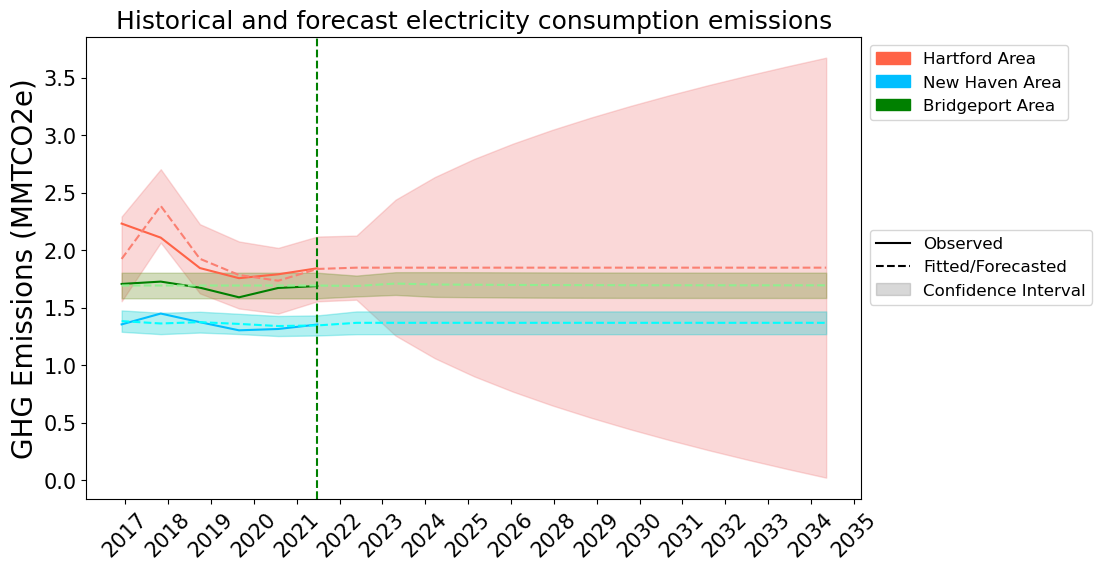

In [39]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
concatenated_predicted_forecast_HEM = pd.concat([emissions_train_HEM,HEM_forecast])

plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_forecast_HEM.index, concatenated_predicted_forecast_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

concatenated_confidence_interval_HEM = pd.concat([train_conf_int_HEM, HEM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_HEM.index, concatenated_confidence_interval_HEM.iloc[:, 0], concatenated_confidence_interval_HEM.iloc[:, 1], color='lightcoral', alpha=0.3)



concatenated_observed_NHM = pd.concat([NHM_train,NHM_test])[1:]
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
concatenated_predicted_forecast_NHM = pd.concat([emissions_train_NHM,NHM_forecast])

plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='deepskyblue')
plt.plot(concatenated_predicted_forecast_NHM.index, concatenated_predicted_forecast_NHM, label='New Haven_Fitted', color='cyan', linestyle='--')

concatenated_confidence_interval_NHM = pd.concat([train_conf_int_NHM, NHM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_NHM.index, concatenated_confidence_interval_NHM.iloc[:, 0], concatenated_confidence_interval_NHM.iloc[:, 1], color='darkturquoise', alpha=0.3)


concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
concatenated_predicted_forecast_BSN = pd.concat([emissions_train_BSN,BSN_forecast])

plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_forecast_BSN.index, concatenated_predicted_forecast_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

concatenated_confidence_interval_BSN = pd.concat([train_conf_int_BSN, BSN_confidence_interval])
plt.fill_between(concatenated_confidence_interval_BSN.index, concatenated_confidence_interval_BSN.iloc[:, 0], concatenated_confidence_interval_BSN.iloc[:, 1], color='olivedrab', alpha=0.3)


# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
deepskyblue_patch = mpatches.Patch(color='deepskyblue', label='New Haven Area')
green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch, green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Historical and forecast electricity consumption emissions', fontsize=18)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=15, rotation=45) 
plt.yticks(fontsize=15)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='green', linestyle='--', label='Year 2022 (X-axis)')


plt.savefig('../../../figures/electricity_forecast.png', dpi=600, bbox_inches='tight')

In [40]:
concatenated_confidence_interval_NHM

,lower New Haven (MMTCO2e),upper New Haven (MMTCO2e)
2017-01-01,1.290504,1.476331
2018-01-01,1.270097,1.455776
2019-01-01,1.283804,1.464964
2020-01-01,1.270968,1.446961
2021-01-01,1.253474,1.428029
2022-01-01,1.258516,1.432973
2023-01-01,1.269682,1.467557
2024-01-01,1.269682,1.467557
2025-01-01,1.269682,1.467557
2026-01-01,1.269682,1.467557
